In [2]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib.gridspec import GridSpec
import datetime as dt

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
cu = pd.read_csv('EDA_customer.csv')
tr = pd.read_csv('EDA_transaction_last1.csv')
pr = pd.read_csv('EDA_product_last1.csv')

In [4]:
cu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   customer_id         100000 non-null  int64  
 1   gender              100000 non-null  object 
 2   age                 100000 non-null  int64  
 3   join_age            100000 non-null  int64  
 4   device              100000 non-null  object 
 5   device_version      100000 non-null  object 
 6   home_location_lat   100000 non-null  float64
 7   home_location_long  100000 non-null  float64
 8   home_location       100000 non-null  object 
 9   birthdate           100000 non-null  object 
 10  first_join_date     100000 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 8.4+ MB


In [5]:
df = tr[['created_at','customer_id','session_id','payment_method','payment_status','promo_amount','promo_code','shipment_fee','product_id','quantity','item_price','buy_age']]
df= pd.merge(df, cu[['customer_id', 'first_join_date','gender','home_location','age']], on='customer_id', how='inner')

In [6]:
# 가격 컬럼, order_date컬럼 생성
df['price'] = df['item_price'] * df['quantity']
df['created_at'] = pd.to_datetime(df['created_at'])
df['order_date'] = df['created_at'].dt.date
df['order_date'] = pd.to_datetime(df['order_date'])
df['first_join_date'] = pd.to_datetime(df['first_join_date'])

In [7]:
df.head()

,created_at,customer_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,product_id,quantity,item_price,buy_age,first_join_date,gender,home_location,age,price,order_date
0,2018-07-29 15:22:01.458193+00:00,5868,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,54728,1,191247,17,2018-07-28,F,Jakarta Raya,24,191247,2018-07-29
1,2018-07-30 12:40:22.365620+00:00,4774,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,Not Promoted,10000,16193,1,145526,22,2018-07-28,F,Sulawesi Selatan,28,145526,2018-07-30
2,2018-09-15 11:51:17.365620+00:00,4774,93325fb6-eb00-4268-bb0e-6471795a0ad0,OVO,Success,0,Not Promoted,10000,53686,4,135174,22,2018-07-28,F,Sulawesi Selatan,28,540696,2018-09-15
3,2018-11-01 11:23:48.365620+00:00,4774,bcad5a61-1b67-448d-8ff4-781d67bc56e4,Credit Card,Success,0,Not Promoted,0,20228,1,271012,22,2018-07-28,F,Sulawesi Selatan,28,271012,2018-11-01
4,2018-12-18 11:20:30.365620+00:00,4774,df1042ab-13e6-4072-b9d2-64a81974c51a,Credit Card,Success,0,Not Promoted,0,55220,1,198753,22,2018-07-28,F,Sulawesi Selatan,28,198753,2018-12-18


In [8]:
df = df.query('payment_status == "Success"').reset_index(drop=True)
df = df[df['order_date']< "2022-07-01"]

### 7월전까지 거래 데이터 사용

In [9]:
last_timestamp = df['order_date'].max() + dt.timedelta(days = 1)
last_timestamp

Timestamp('2022-07-01 00:00:00')

In [10]:
def average_purchase_price(x):
    total_price = x.sum()
    unique_sessions = x.nunique()
    return total_price / unique_sessions

rfm = df.groupby('customer_id').agg({
    'order_date': lambda x: (last_timestamp - x.max()).days,
    'session_id': 'nunique',
    'price': average_purchase_price
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

rfm

,Recency,Frequency,Monetary
customer_id,,,
3,5,49,299658.463768
8,47,7,482657.500000
9,34,6,325458.125000
11,116,1,192025.000000
15,177,5,233470.222222
...,...,...,...
99992,37,12,249098.294118
99995,8,56,404170.581081
99997,797,1,216461.000000


In [11]:
# RFM 세그먼트 구축
r_labels = range(4, 0, -1)  # 4, 3, 2, 1
f_labels = range(1, 5)  # 1, 2, 3, 4
m_labels = range(1, 5)  # 1, 2, 3, 4

r_quartiles = pd.qcut(rfm['Recency'], q=4, labels=r_labels)
f_quartiles = pd.qcut(rfm['Frequency'], q=4, labels=f_labels)
m_quartiles = pd.qcut(rfm['Monetary'], q=4, labels=m_labels)

# assign() 함수를 통해 한 번에 여러 번수를 만들 수 있음
rfm = rfm.assign(R=r_quartiles, F=f_quartiles, M=m_quartiles)

In [12]:
def add_rfm(x):
    return str(str(x['R']) + str(x['F']) + str(x['M']))
    
rfm['RFM_Segment'] = rfm.apply(add_rfm,axis=1 )
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)

In [13]:
rfm

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
customer_id,,,,,,,,
3,5,49,299658.463768,4,4,2,4.04.02.0,10
8,47,7,482657.500000,3,3,4,3.03.04.0,10
9,34,6,325458.125000,3,2,2,3.02.02.0,7
11,116,1,192025.000000,2,1,1,2.01.01.0,4
15,177,5,233470.222222,2,2,1,2.02.01.0,5
...,...,...,...,...,...,...,...,...
99992,37,12,249098.294118,3,3,1,3.03.01.0,7
99995,8,56,404170.581081,4,4,4,4.04.04.0,12
99997,797,1,216461.000000,1,1,1,1.01.01.0,3


In [14]:
rfm.groupby(['RFM_Segment']).size().sort_values(ascending=False)

RFM_Segment
1.01.01.0    4727
4.04.03.0    4009
1.01.04.0    2343
4.04.02.0    2044
1.01.02.0    1865
4.04.04.0    1836
3.04.03.0    1777
2.01.01.0    1744
2.02.01.0    1506
3.03.02.0    1424
2.02.04.0    1342
2.02.02.0    1322
3.03.04.0    1300
1.01.03.0    1204
3.03.03.0    1203
3.04.02.0    1145
2.03.02.0    1040
3.04.04.0    1030
2.03.04.0     950
4.03.02.0     919
2.02.03.0     881
4.03.04.0     807
2.03.03.0     806
2.01.04.0     795
2.01.02.0     731
1.02.01.0     719
4.03.03.0     709
3.02.01.0     700
3.02.04.0     646
3.02.02.0     618
3.03.01.0     594
2.03.01.0     571
1.02.04.0     566
2.01.03.0     525
1.02.02.0     511
3.01.01.0     492
3.02.03.0     415
4.03.01.0     396
4.02.01.0     345
4.02.02.0     325
1.02.03.0     321
4.02.04.0     295
4.01.01.0     251
3.01.04.0     234
4.02.03.0     215
3.01.02.0     201
4.01.04.0     142
4.01.02.0     133
3.04.01.0     127
3.01.03.0     127
4.04.01.0     126
4.01.03.0      79
2.04.03.0      37
2.04.02.0      24
2.04.04.0      2

In [15]:
rfm[rfm['RFM_Segment'] == '111'].head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
customer_id,,,,,,,,


In [16]:
# RFM Score Summary
rfm.groupby('RFM_Score').agg({'Recency':'mean',
                              'Frequency':'mean',
                              'Monetary':['mean', 'count']}).round(1)

Recency Frequency  Monetary      
             mean      mean      mean count
RFM_Score                                  
3           986.5       1.2  188365.4  4727
4           574.0       1.7  240695.8  4328
5           426.0       2.6  277214.9  4452
6           464.4       3.2  474557.4  6243
7           163.1       5.6  415472.6  5107
8            96.1       8.1  410303.8  5177
9            53.3      15.2  408171.1  5383
10           25.7      32.8  390519.9  6145
11           13.8      52.4  402951.5  5846
12            9.3      47.3  457903.8  1836

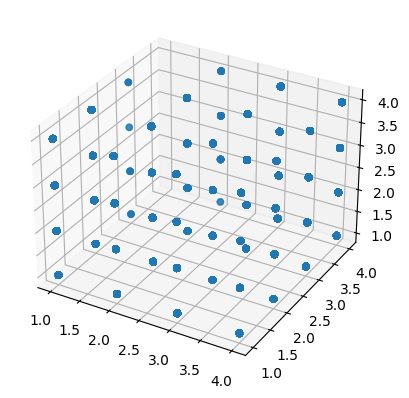

In [17]:
ax = plt.axes(projection='3d')
ax.scatter3D( rfm["R"], rfm["F"], rfm["M"])

In [18]:
labels = ["silver", "gold", "platinum"]
rfm['RFM_class'] = pd.qcut(rfm['RFM_Score'], 3, labels)
rfm

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_class
customer_id,,,,,,,,,
3,5,49,299658.463768,4,4,2,4.04.02.0,10,platinum
8,47,7,482657.500000,3,3,4,3.03.04.0,10,platinum
9,34,6,325458.125000,3,2,2,3.02.02.0,7,gold
11,116,1,192025.000000,2,1,1,2.01.01.0,4,silver
15,177,5,233470.222222,2,2,1,2.02.01.0,5,silver
...,...,...,...,...,...,...,...,...,...
99992,37,12,249098.294118,3,3,1,3.03.01.0,7,gold
99995,8,56,404170.581081,4,4,4,4.04.04.0,12,platinum
99997,797,1,216461.000000,1,1,1,1.01.01.0,3,silver


In [19]:
rfm.groupby('RFM_class').agg({'Recency':'mean',
                                    'Frequency':'mean',
                                    'Monetary':['mean', 'count']}).round(1)

Recency Frequency  Monetary       
             mean      mean      mean  count
RFM_class                                   
silver      604.7       2.3  310326.9  19750
gold        103.2       9.7  411255.9  15667
platinum     18.5      43.0  404723.4  13827

<Axes: xlabel='RFM_class', ylabel='RFM_Score'>

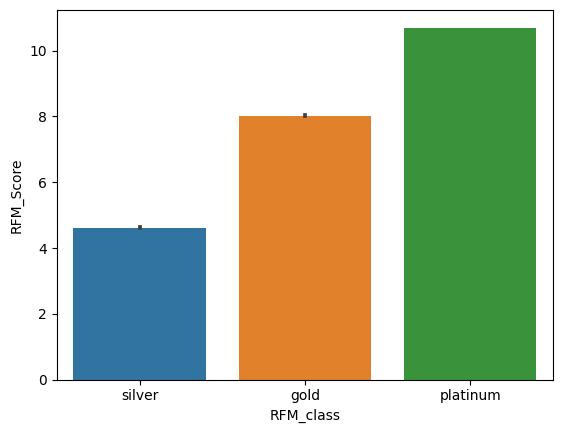

In [20]:
sns.barplot(data=rfm, x="RFM_class", y="RFM_Score")

<Axes: xlabel='RFM_class', ylabel='RFM_Score'>

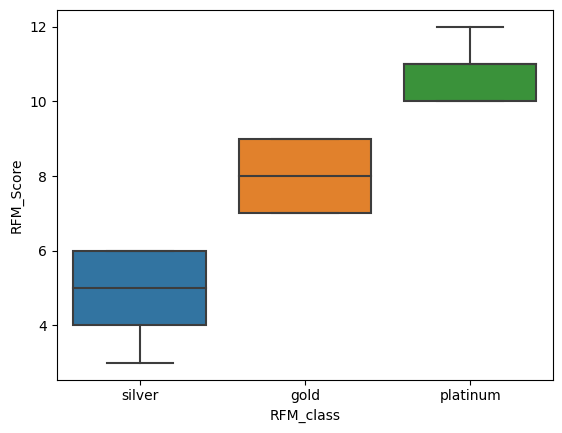

In [21]:
sns.boxplot(data=rfm, x="RFM_class", y="RFM_Score")

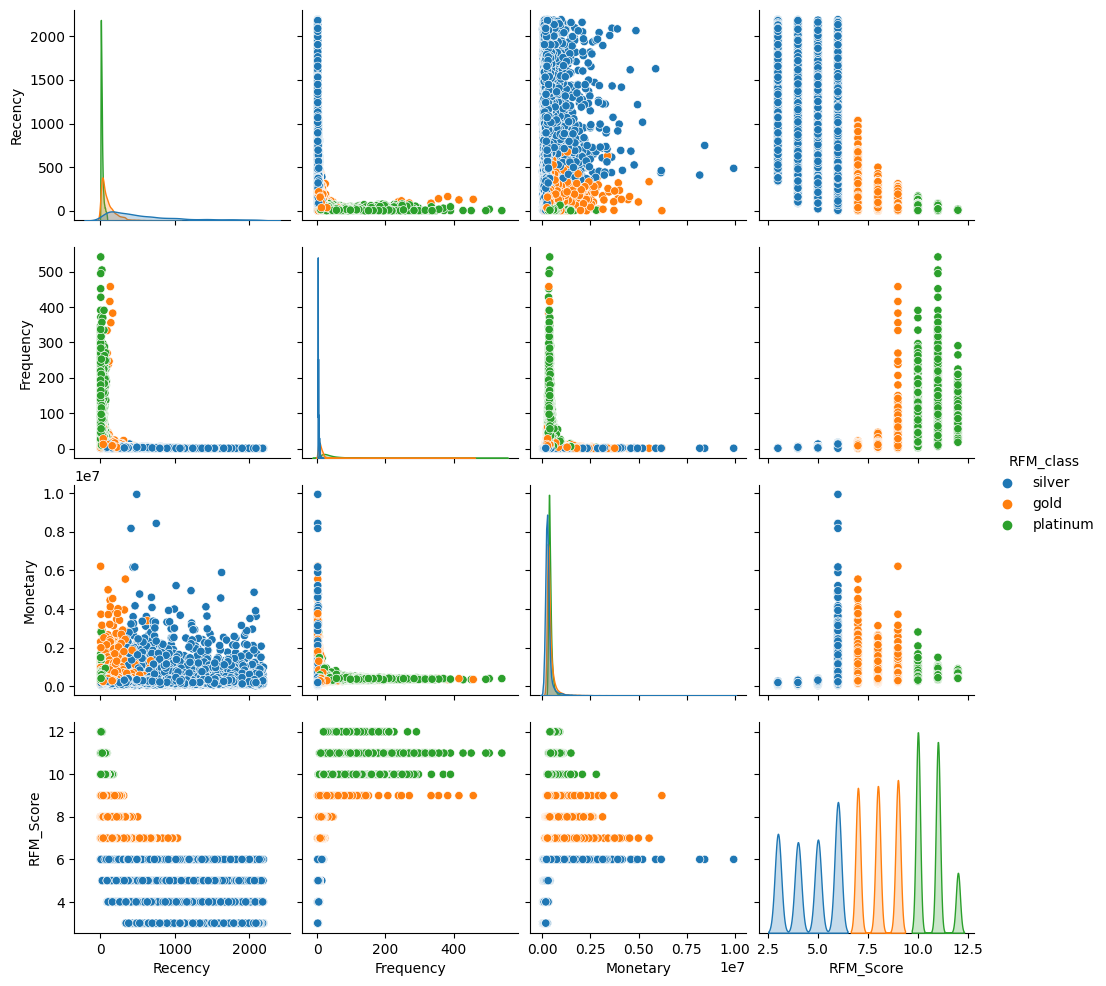

In [22]:
sns.pairplot(data = rfm, hue = 'RFM_class')

In [23]:
selected_columns = ['Recency', 'Frequency', 'Monetary','RFM_Score']
selected_rfm = rfm[selected_columns]

# 상관 계수 계산
corr = selected_rfm.corr()
corr

,Recency,Frequency,Monetary,RFM_Score
Recency,1.000000,-0.301748,-0.005629,-0.638135
Frequency,-0.301748,1.000000,-0.000175,0.549887
Monetary,-0.005629,-0.000175,1.000000,0.239980
RFM_Score,-0.638135,0.549887,0.239980,1.000000


<Axes: >

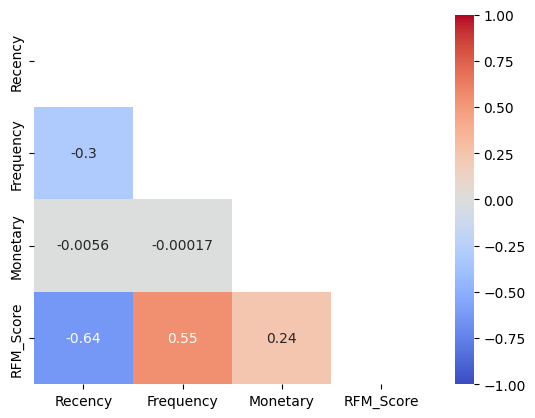

In [24]:
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, cmap = 'coolwarm', vmin = -1, vmax = 1, annot = True, mask = mask)

In [25]:
clas=rfm[['RFM_Segment','RFM_Score','RFM_class']].reset_index()

In [26]:
clas

,customer_id,RFM_Segment,RFM_Score,RFM_class
0,3,4.04.02.0,10,platinum
1,8,3.03.04.0,10,platinum
2,9,3.02.02.0,7,gold
3,11,2.01.01.0,4,silver
4,15,2.02.01.0,5,silver
...,...,...,...,...
49239,99992,3.03.01.0,7,gold
49240,99995,4.04.04.0,12,platinum
49241,99997,1.01.01.0,3,silver
49242,99998,2.03.02.0,7,gold


In [38]:
# clas.to_csv('customer_class2.csv',index=False, encoding="utf-8-sig", mode="w")

### 세부분석

In [28]:
df_join = df[['session_id','order_date','customer_id','gender', 'home_location','first_join_date','promo_amount','promo_code','price','product_id','age']]

In [29]:
rfm_df = pd.merge(df_join,rfm,on='customer_id',how='inner')

In [30]:
target= pd.merge(rfm_df, pr[['product_id','usage','masterCategory','subCategory','articleType']], on='product_id', how='inner')
target.head()

,session_id,order_date,customer_id,gender,home_location,first_join_date,promo_amount,promo_code,price,product_id,...,R,F,M,RFM_Segment,RFM_Score,RFM_class,usage,masterCategory,subCategory,articleType
0,3abaa6ce-e320-4e51-9469-d9f3fa328e86,2018-07-29,5868,F,Jakarta Raya,2018-07-28,1415,WEEKENDSERU,191247,54728,...,1,1,1,1.01.01.0,3,silver,Casual,Footwear,Shoes,Casual Shoes
1,c7d4a5a2-362b-4042-a971-a55f84e0619f,2021-01-15,82831,M,Kalimantan Selatan,2016-10-01,0,Not Promoted,222512,54728,...,3,4,3,3.04.03.0,10,platinum,Casual,Footwear,Shoes,Casual Shoes
2,141a3f3b-360e-4489-bc10-91528e9e1139,2020-06-04,47013,M,Yogyakarta,2018-07-21,0,Not Promoted,245159,54728,...,3,4,3,3.04.03.0,10,platinum,Casual,Footwear,Shoes,Casual Shoes
3,aadf43f6-59be-4b2f-9338-ccec0b2abf40,2019-02-05,17135,M,Sulawesi Tengah,2017-10-01,0,Not Promoted,263371,54728,...,4,4,2,4.04.02.0,10,platinum,Casual,Footwear,Shoes,Casual Shoes
4,ae213ea2-c5bb-45aa-8a27-820d33c873aa,2020-11-04,70185,M,Sumatera Barat,2017-07-22,0,Not Promoted,2403496,54728,...,4,4,3,4.04.03.0,11,platinum,Casual,Footwear,Shoes,Casual Shoes


In [31]:
st = pd.read_csv('customer_status_NEW.csv')

In [32]:
st.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99878 entries, 0 to 99877
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   customer_id      99878 non-null  int64 
 1   first_join_date  99878 non-null  object
 2   2017-01-01       99878 non-null  object
 3   2017-05-01       99878 non-null  object
 4   2017-09-01       99878 non-null  object
 5   2018-01-01       99878 non-null  object
 6   2018-05-01       99878 non-null  object
 7   2018-09-01       99878 non-null  object
 8   2019-01-01       99878 non-null  object
 9   2019-05-01       99878 non-null  object
 10  2019-09-01       99878 non-null  object
 11  2020-01-01       99878 non-null  object
 12  2020-05-01       99878 non-null  object
 13  2020-09-01       99878 non-null  object
 14  2021-01-01       99878 non-null  object
 15  2021-05-01       99878 non-null  object
 16  2021-09-01       99878 non-null  object
 17  2022-01-01       99878 non-null

In [33]:
st['2020-09-01'].unique()

array(['low_potential_new', 'active_new', 'not_join_yet',
       'active_existing', 'dormant', 'inactive_new', 'resurrected'],
      dtype=object)

In [34]:
target2 = pd.merge(target,st[['customer_id','2022-05-01']],on='customer_id',how='inner')

In [35]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1165730 entries, 0 to 1165729
Data columns (total 24 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   session_id       1165730 non-null  object        
 1   order_date       1165730 non-null  datetime64[ns]
 2   customer_id      1165730 non-null  int64         
 3   gender           1165730 non-null  object        
 4   home_location    1165730 non-null  object        
 5   first_join_date  1165730 non-null  datetime64[ns]
 6   promo_amount     1165730 non-null  int64         
 7   promo_code       1165730 non-null  object        
 8   price            1165730 non-null  int64         
 9   product_id       1165730 non-null  int64         
 10  age              1165730 non-null  int64         
 11  Recency          1165730 non-null  int64         
 12  Frequency        1165730 non-null  int64         
 13  Monetary         1165730 non-null  float64       
 14  R 

In [41]:
# 주문주기 컬럼생성
target = target.sort_values(by=['customer_id', 'order_date'])
target['date_diff'] = target.groupby('customer_id')['order_date'].diff().dt.days
target['date_diff'] = target.groupby(['customer_id', 'order_date'])['date_diff'].transform('first')

In [36]:
# 각 session_id를 고유하게 카운트
unique_sessions = target.drop_duplicates(subset='session_id')

# RFM_class 별로 그룹화하고 거래량을 집계
classwise_transactions = unique_sessions.groupby('RFM_class').size().reset_index(name='number_of_transactions')

# 결과를 출력
classwise_transactions.sort_values(by='number_of_transactions', ascending=False)

,RFM_class,number_of_transactions
2,platinum,595011
1,gold,152222
0,silver,44641


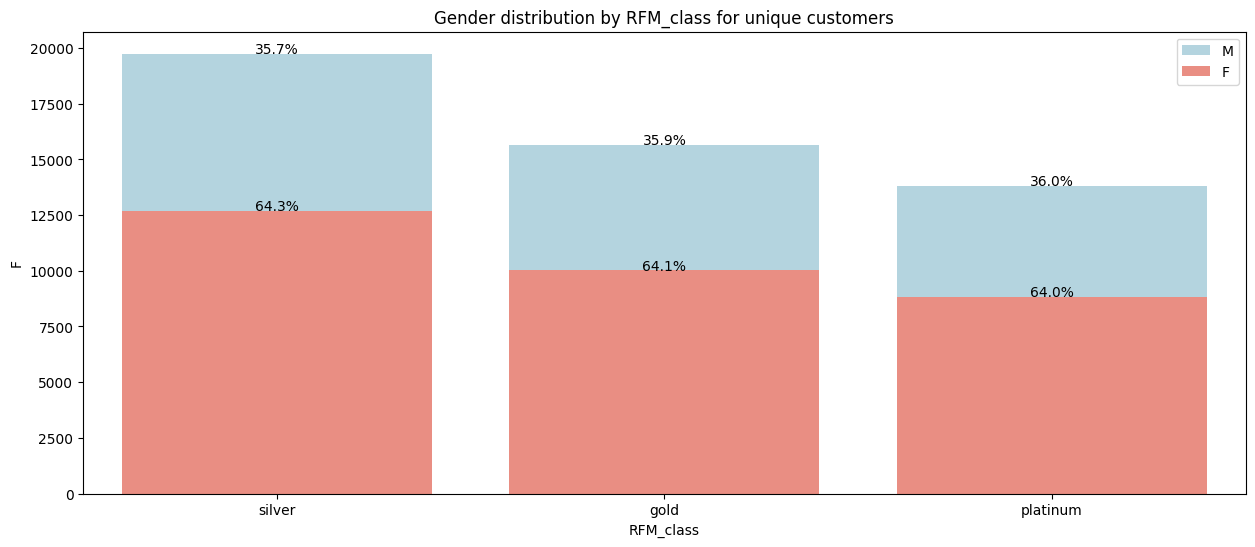

In [37]:
unique_customers = target.drop_duplicates(subset='customer_id')

# RFM_class 별 gender 분포 계산
gender_distribution = unique_customers.groupby(['RFM_class', 'gender']).size().reset_index(name='count')
gender_pivot = gender_distribution.pivot_table(index='RFM_class', columns='gender', values='count').reset_index()
gender_pivot['Total'] = gender_pivot['F'] + gender_pivot['M']
gender_pivot['F_percentage'] = 100 * gender_pivot['F'] / gender_pivot['Total']
gender_pivot['M_percentage'] = 100 * gender_pivot['M'] / gender_pivot['Total']

# 그래프 그리기
plt.figure(figsize=(15, 6))
barplot = sns.barplot(x='RFM_class', y='Total', data=gender_pivot, color='lightblue', label='M')
sns.barplot(x='RFM_class', y='F', data=gender_pivot, color='salmon', label='F')

# 막대 위에 비율 표시
for idx, p in enumerate(barplot.patches[:len(gender_pivot)]):
    barplot.text(p.get_x() + p.get_width()/2., p.get_height() + 3, f"{gender_pivot['M_percentage'].iloc[idx]:.1f}%", ha="center")
for idx, p in enumerate(barplot.patches[len(gender_pivot):]):
    barplot.text(p.get_x() + p.get_width()/2., p.get_height() + 3, f"{gender_pivot['F_percentage'].iloc[idx]:.1f}%", ha="center")

plt.legend()
plt.title('Gender distribution by RFM_class for unique customers')
plt.show()

In [39]:
target['is_promo_nonzero'] = target['promo_amount'] != 0
cluster_promo_ratio = target.groupby('RFM_class')['is_promo_nonzero'].mean() * 100
cluster_promo_ratio

RFM_class
silver      38.391236
gold        38.319902
platinum    38.827939
Name: is_promo_nonzero, dtype: float64

In [40]:
target['is_promo_nonzero'].mean()*100

38.706389987389876

In [43]:
target.groupby('RFM_class')['date_diff'].mean()

RFM_class
silver      224.282181
gold         87.534857
platinum     23.909397
Name: date_diff, dtype: float64

In [44]:
dd = target.groupby(['RFM_class']).agg({
    'date_diff': ['min', 'max', 'mean']
}).reset_index()
dd

RFM_class date_diff                    
                  min     max        mean
0    silver       0.0  1625.0  224.282181
1      gold       0.0  1333.0   87.534857
2  platinum       0.0   366.0   23.909397

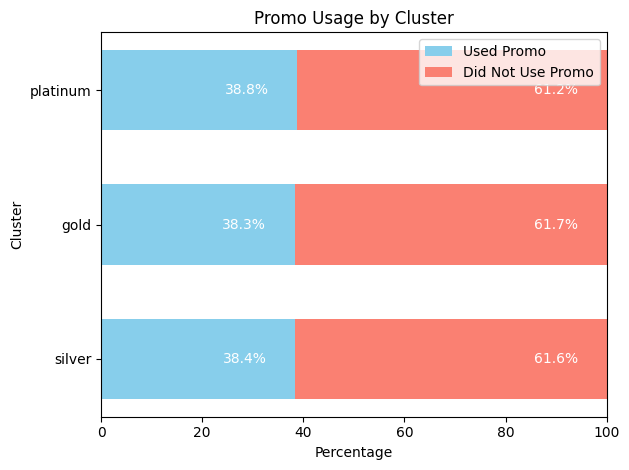

In [46]:
target['is_promo_nonzero'] = target['promo_amount'] != 0
cluster_promo_ratio = target.groupby('RFM_class')['is_promo_nonzero'].mean() * 100
no_promo_ratio = 100 - cluster_promo_ratio

# 그래프 그리기
clusters = cluster_promo_ratio.index
bar_width = 0.6  # 막대의 너비

# Promo 사용 비율
bars1 = plt.barh(clusters, cluster_promo_ratio, color='skyblue', label='Used Promo', height=bar_width)
# Promo 미사용 비율
bars2 = plt.barh(clusters, no_promo_ratio, left=cluster_promo_ratio, color='salmon', label='Did Not Use Promo', height=bar_width)

# 각 막대에 텍스트 레이블 추가
for bar in bars1:
    plt.text(bar.get_width() - 10, bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.1f}%", ha='center', va='center', color='white', fontsize=10)

for bar in bars2:
    plt.text(bar.get_x() + bar.get_width() - 10, bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.1f}%", ha='center', va='center', color='white', fontsize=10)

# 그래프 설정
plt.xlabel('Percentage')
plt.ylabel('Cluster')
plt.title('Promo Usage by Cluster')
plt.legend(loc='upper right',bbox_to_anchor=(1,1))
plt.xlim(0, 100)  # x축 범위를 0~100%로 설정
plt.tight_layout()
plt.show()

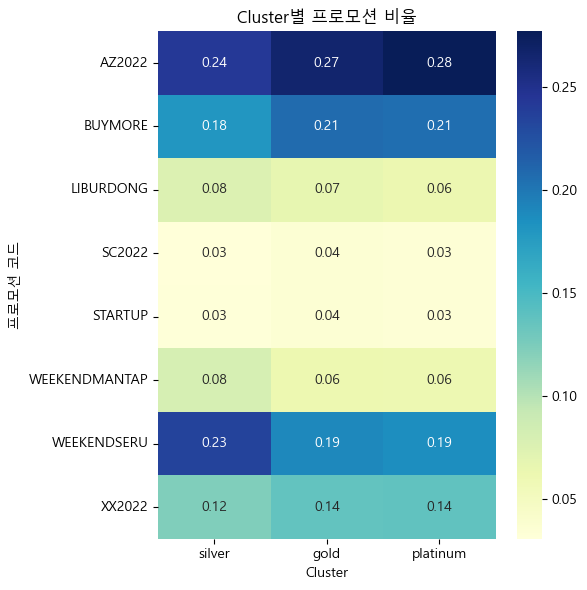

In [48]:
promo = target.query('promo_code != "Not Promoted"')
# 클러스터별 프로모션 코드 빈도 계산
promo_counts_by_cluster = promo.groupby(['RFM_class', 'promo_code'])['order_date'].count().reset_index()

# 클러스터별 총 거래 횟수
total_counts_by_cluster = promo_counts_by_cluster.groupby('RFM_class')['order_date'].sum()

# 비율 계산
promo_counts_by_cluster['cluster_ratio'] = promo_counts_by_cluster.groupby('RFM_class')['order_date'].apply(lambda x: x / total_counts_by_cluster[x.name]).values

# 피벗 테이블로 데이터 변환
pivot_data = promo_counts_by_cluster.pivot(index='promo_code', columns='RFM_class', values='cluster_ratio')

# 히트맵
plt.figure(figsize=(6, 6))
plt.rc('font', family='Malgun Gothic') 
sns.heatmap(data=pivot_data, annot=True, fmt=".2f", cmap='YlGnBu', xticklabels=True, yticklabels=True)
plt.xlabel('Cluster')
plt.ylabel('프로모션 코드')
plt.title('Cluster별 프로모션 비율')

plt.tight_layout()
plt.show()

In [ ]:
# pd.set_option('display.float_format', '{:.2f}'.format)

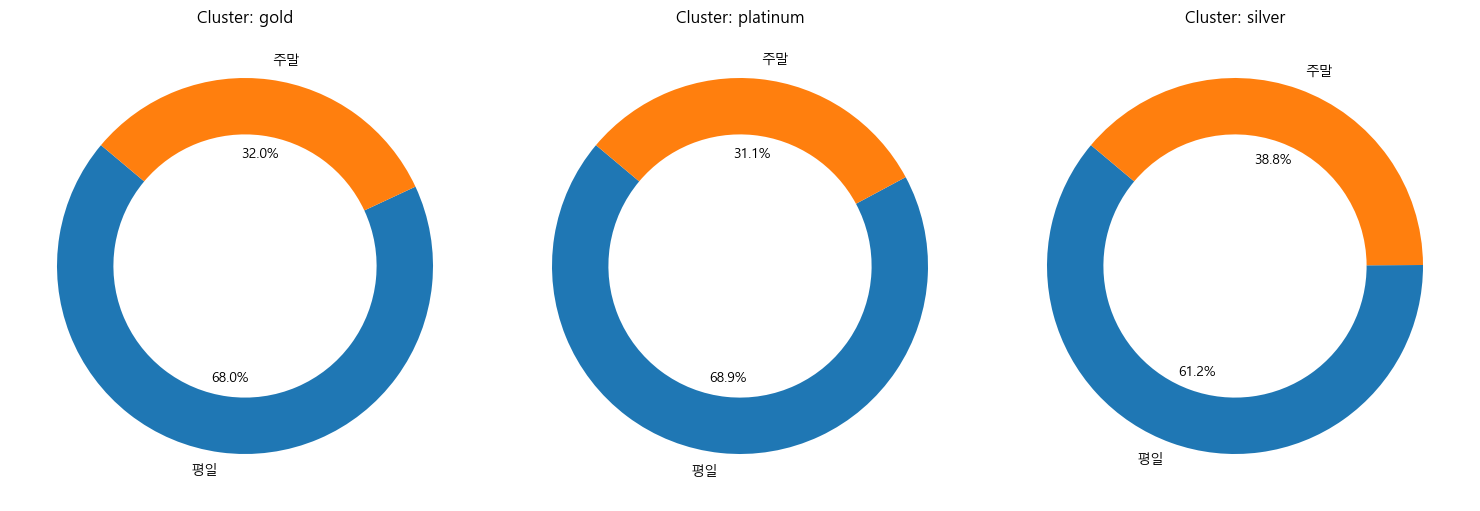

In [49]:
# order_date에서 요일 정보를 추출하여 '주말'과 '평일'로 분류하는 새로운 컬럼 'day_type'을 생성합니다.
target['day_type'] = target['order_date'].dt.dayofweek.map({0: '평일', 1: '평일', 2: '평일', 3: '평일', 4: '평일', 5: '주말', 6: '주말'})

clusters = sorted(target['RFM_class'].unique())

# 클러스터의 수만큼 subplot을 생성합니다.
fig, axes = plt.subplots(nrows=1, ncols=len(clusters), figsize=(5 * len(clusters), 5))

for ax, cluster in zip(axes, clusters):
    cluster_data = target[target['RFM_class'] == cluster]
    
    # 클러스터와 거래요일별로 데이터를 집계합니다.
    day_type_counts = cluster_data['day_type'].value_counts(normalize=True)
    
    ax.pie(day_type_counts, labels=day_type_counts.index, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
    ax.set_title(f'Cluster: {cluster}')

plt.tight_layout()
plt.show()

In [451]:
pip install squarify

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip
